# ***Allen's interval algebra***

## ***Import required packages***

In [ ]:
try:
  import pm4py
  
except:
  !pip install -U pm4py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import scipy

from typing import Tuple
from matplotlib.patches import Rectangle
from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

## ***Import the event log and convert it into the data frame***

In [ ]:
log = xes_importer.apply("exercise6.xes")
el_df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
el_df.head()

/usr/local/lib/python3.9/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


## ***Clean the event log***

In [ ]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
  df["start_ts"] = df[df["lifecycle:transition"] == "start"]["time:timestamp"].map(lambda t: t.timestamp())
  df["complete_ts"] = df[df["lifecycle:transition"] == "complete"]["time:timestamp"].map(lambda t: t.timestamp())
  df.drop(["org:resource", "lifecycle:transition", "time:timestamp"], axis=1, inplace=True)
  df = df.rename(columns={"concept:name": "task_name", "case:concept:name": "case_id"})
  df = df[["case_id", "task_name", "start_ts", "complete_ts"]]
  df = df.groupby(["case_id", "task_name"], as_index=False).agg({"start_ts": "first", "complete_ts": "last"})
  df["interval_ts"] = df["complete_ts"] - df["start_ts"]
  df.sort_values("case_id", inplace=True)

  return df


el_df_cleaned = clean(el_df.copy())
el_df_cleaned.head()

,case_id,task_name,start_ts,complete_ts,interval_ts
0,0,advise claimant on reimbursement,1.288566e+09,1.335136e+09,46569600.0
1,0,assess claim,1.205795e+09,1.286924e+09,81129600.0
2,0,check if sufficient information is available,1.136070e+09,1.137193e+09,1123200.0
3,0,close claim,1.335136e+09,1.335481e+09,345600.0
4,0,determine likelihood of claim,1.201648e+09,1.205795e+09,4147200.0


## ***Display all tasks***

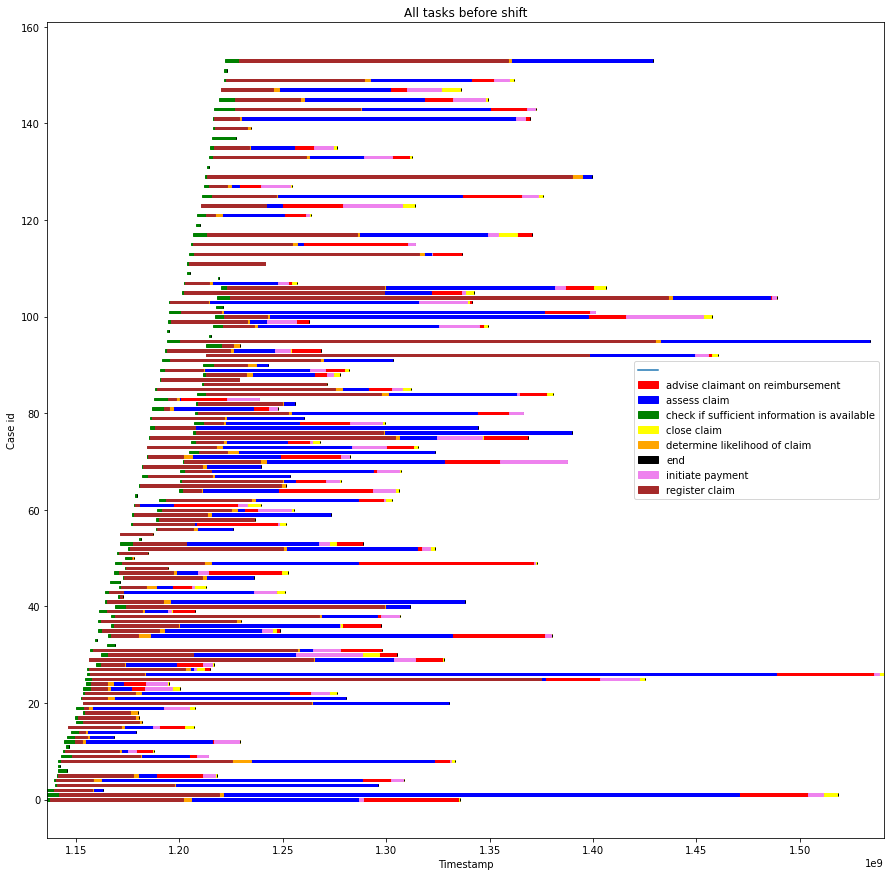

In [ ]:
def display_all_tasks(df: pd.DataFrame, title: str) -> None:
  _, ax = plt.subplots(figsize=(15, 15))
  ax.plot([0, 10], [0, 10])
  colors_mapping = {"advise claimant on reimbursement": "red", "assess claim": "blue",
                    "check if sufficient information is available": "green",
                    "close claim": "yellow", "determine likelihood of claim": "orange",
                    "end": "black", "initiate payment": "violet", "register claim": "brown"}

  for i in range(len(df)):
    case_id = int(df["case_id"][i])
    task_name = df["task_name"][i]
    start_ts = df["start_ts"][i]
    interval_ts = df["interval_ts"][i]
    color = colors_mapping[task_name]
    ax.add_patch(Rectangle((start_ts, case_id - 0.25), interval_ts, 0.5, color=color))

  plt.xlim([df["start_ts"].min(), df["start_ts"].max()])
  plt.legend(["", "advise claimant on reimbursement", "assess claim",
              "check if sufficient information is available", "close claim",
              "determine likelihood of claim", "end", "initiate payment",
              "register claim"])
  plt.xlabel("Timestamp"), plt.ylabel("Case id")
  plt.title(title)
  plt.show()


display_all_tasks(el_df_cleaned.copy(), "All tasks before shift")

## ***Translate all tasks***

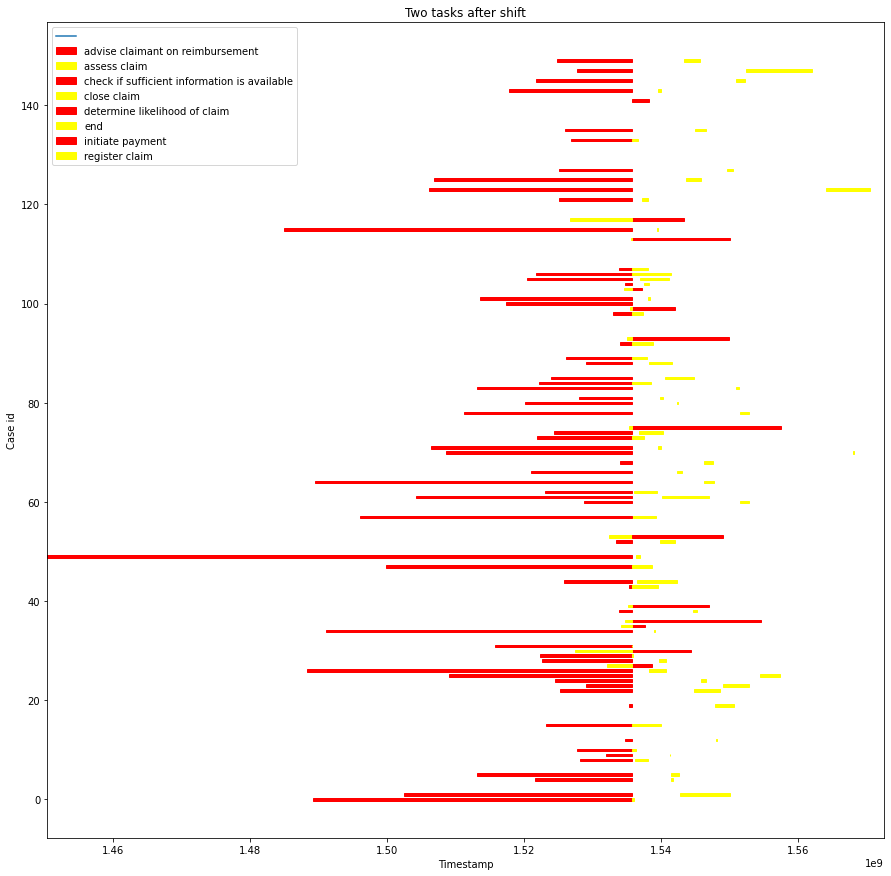

<ipython-input-60-2a964da2c10d>:123: RankWarning: Polyfit may be poorly conditioned
  aa.approximate(aa.task1)


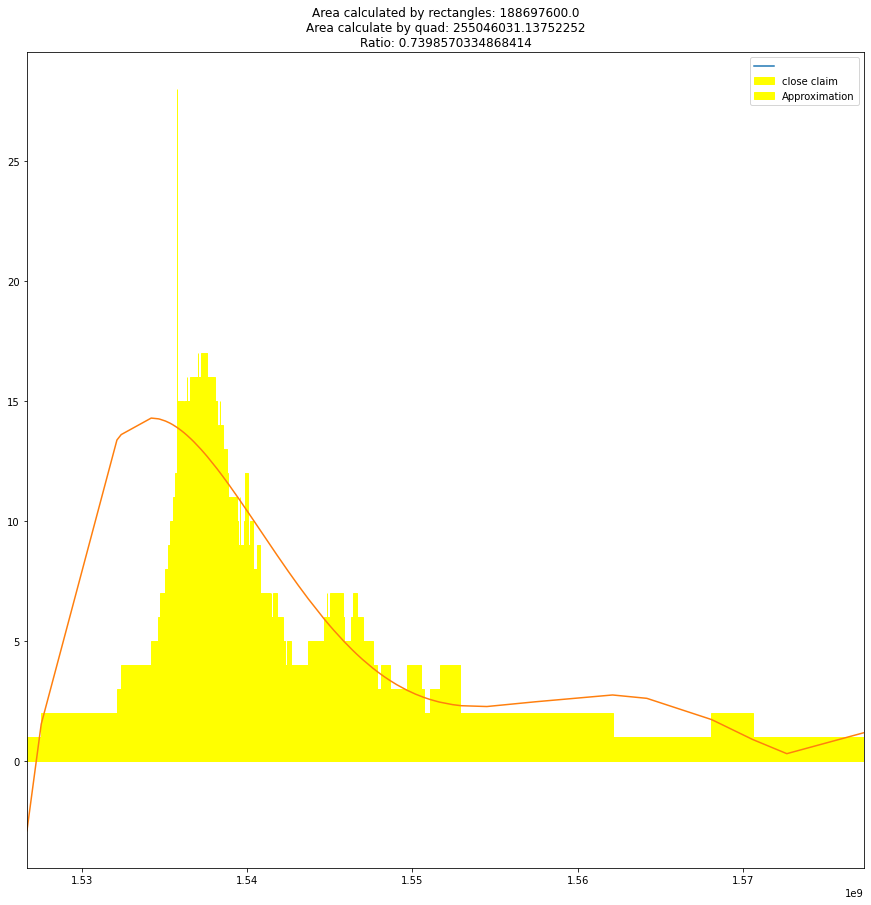

<ipython-input-60-2a964da2c10d>:124: RankWarning: Polyfit may be poorly conditioned
  aa.approximate(aa.task2)


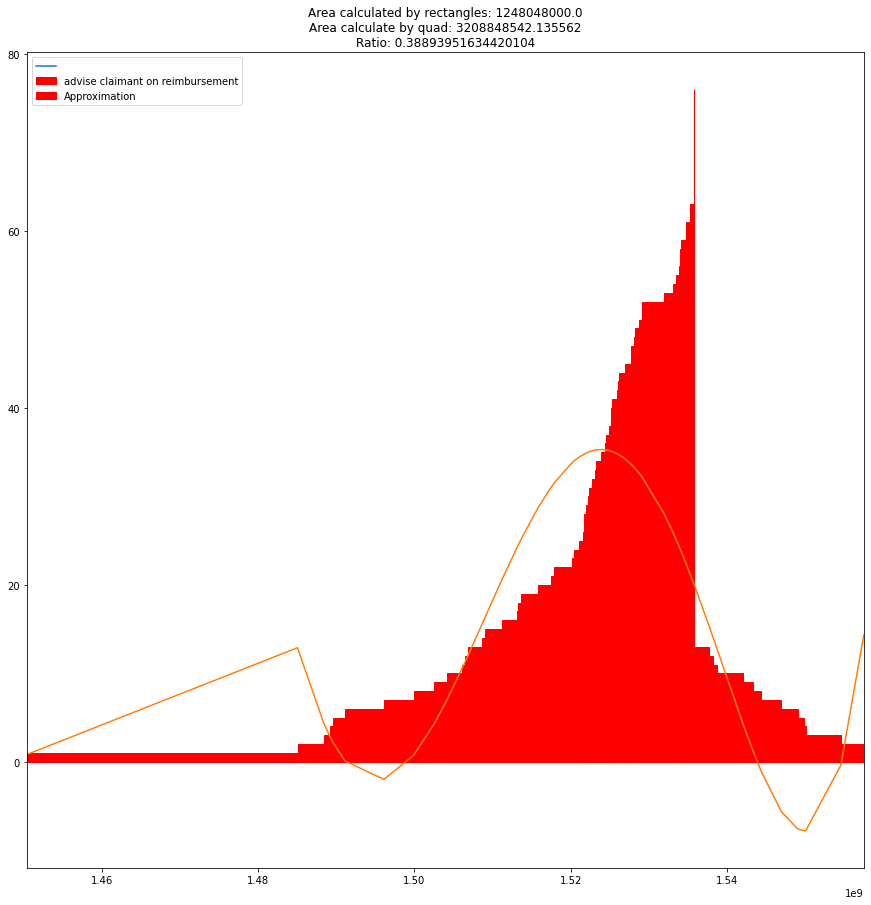

<ipython-input-60-2a964da2c10d>:98: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  self.area_overlapped = scipy.integrate.quad(conv_fun, 0, min([task1.timestamps[-1], task2.timestamps[-1]]))[0]


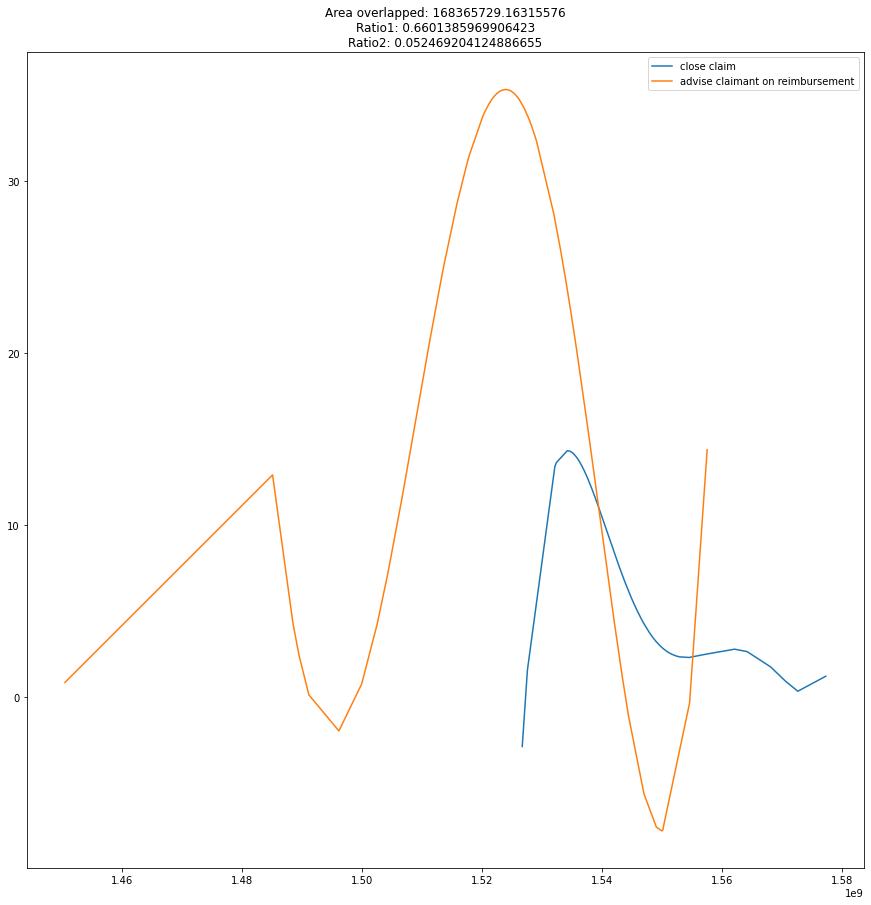

In [ ]:
class Task:
  def __init__(self, name: str, color: str) -> None:
    self.name = name
    self.color = color
    self.timestamps = None
    self.frequencies = None
    self.N = None
    self.coef = None
    self.area_rect = None
    self.area_poly = None


class AllenAnalysis:
  def __init__(self, df: pd.DataFrame, task1: Task, task2: Task, degree: int) -> None:
    self.df = df[(df["task_name"] == task1.name) | (df["task_name"] == task2.name)].reset_index()
    self.N = len(self.df)
    self.task1 = task1
    self.task2 = task2
    self.degree = degree
    self.area_overlapped = None

  def get(self) -> None:
    return self.df

  def shift(self) -> None:
    complete_timestamps = {}

    for i in range(self.N):
      case_id = self.df["case_id"][i]
      complete_ts = self.df["complete_ts"][i]

      if not case_id in complete_timestamps:
        complete_timestamps[case_id] = complete_ts

      else:
        complete_timestamps[case_id] = min(complete_timestamps[case_id], complete_ts)

    max_complete_ts = max(complete_timestamps.values())
    shifts = {case_id: (max_complete_ts - complete_ts) for case_id, complete_ts in complete_timestamps.items()}

    start_ts_list = []
    complete_ts_list = []

    for i in range(self.N):
      case_id = self.df["case_id"][i]
      shift = shifts[case_id]
      start_ts_list.append(self.df["start_ts"][i] + shift)
      complete_ts_list.append(self.df["complete_ts"][i] + shift)

    self.df["start_ts"] = start_ts_list
    self.df["complete_ts"] = complete_ts_list

  def combine_task_intervals(self, task: Task) -> None:
    df = self.df[self.df["task_name"] == task.name].reset_index()
    timestamps = np.array(sorted(list(df["start_ts"]) + list(df["complete_ts"])))
    frequencies = np.array([0] * len(timestamps))

    for i in range(len(df)):
      start_ts = df["start_ts"][i]
      complete_ts = df["complete_ts"][i]
      start_idx = list(timestamps).index(start_ts)
      complete_idx = list(timestamps).index(complete_ts)

      for j in range(start_idx, complete_idx + 1):
        frequencies[j] = frequencies[j] + 1

    task.timestamps = timestamps
    task.frequencies = frequencies
    task.N = len(timestamps)

  def approximate(self, task: Task) -> None:
    timestamps = task.timestamps
    frequencies = task.frequencies
    coef = np.polyfit(timestamps, frequencies, deg=self.degree)
    area_rect = sum([((timestamps[i + 1] - timestamps[i]) * frequencies[i]) for i in range(task.N - 1)])
    area_poly = scipy.integrate.quad(lambda x, p=coef: np.polyval(p, x), timestamps[0], timestamps[-1])[0]
    _, ax = plt.subplots(figsize=(15, 15))
    ax.plot([0, 10], [0, 10])

    for i in range(task.N - 1):
      t1 = timestamps[i]
      t2 = timestamps[i + 1]
      freq = frequencies[i]
      ax.add_patch(Rectangle((t1, 0), t2 - t1, freq, color=task.color))

    plt.legend(["", task.name, "Approximation"])
    plt.plot(timestamps, np.polyval(coef, timestamps))
    plt.xlim([min(timestamps), max(timestamps)])
    plt.title(f"Area calculated by rectangles: {area_rect}\nArea calculate by quad: {area_poly}\nRatio: {area_rect / area_poly}")
    plt.show()

    task.coef = coef
    task.area_rect = area_rect
    task.area_poly = area_poly

  def overlap(self) -> None:
    conv_fun = lambda x, p1=task1.coef, p2=task2.coef: max([0, min([np.polyval(p1, x), np.polyval(p2, x)])])
    self.area_overlapped = scipy.integrate.quad(conv_fun, 0, min([task1.timestamps[-1], task2.timestamps[-1]]))[0]
    title = f"Area overlapped: {self.area_overlapped}\n"
    title += f"Ratio1: {self.area_overlapped / self.task1.area_poly}\n"
    title += f"Ratio2: {self.area_overlapped / self.task2.area_poly}"

    plt.figure(figsize=(15, 15))
    plt.plot(task1.timestamps, np.polyval(task1.coef, task1.timestamps))
    plt.plot(task2.timestamps, np.polyval(task2.coef, task2.timestamps))
    plt.legend([task1.name, task2.name])
    plt.title(title)
    plt.show()


# task1 = Task("register claim", "brown")
# task2 = Task("advise claimant on reimbursement", "red")
# task1 = Task("register claim", "brown")
# task2 = Task("assess claim", "blue")
task1 = Task("close claim", "yellow")
task2 = Task("advise claimant on reimbursement", "red")

aa = AllenAnalysis(el_df_cleaned.copy(), task1, task2, 7)
aa.shift()
display_all_tasks(aa.get().copy(), "Two tasks after shift")
aa.combine_task_intervals(aa.task1)
aa.combine_task_intervals(aa.task2)
aa.approximate(aa.task1)
aa.approximate(aa.task2)
aa.overlap()

In [ ]:
# try:
#   os.remove("/content/event_log.xes.gz")
#   os.remove("/content/event_log.xes")

# except:
#   pass
  
# !wget -O "/content/event_log.xes.gz" https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf
# os.system('gzip -dk event_log.xes.gz')

# el = xes_importer.apply("/content/event_log.xes")
# el_df = log_converter.apply(el, variant=log_converter.Variants.TO_DATA_FRAME)
# el_df.head()


# !wget -O "/content/event_log.csv" https://data.4tu.nl/file/e9c00fe9-c87a-450e-8bd6-d5e06a6b309a/9d7cd406-9826-4adf-8418-c751b475f556

# el_df = pd.read_csv("/content/event_log.csv", sep=";")
# el_df.head()